In [1]:
%load_ext dotenv
%dotenv

In [7]:
import os
import pandas as pd
from geopy.geocoders import GoogleV3
from geopy.extra.rate_limiter import RateLimiter
import numpy as np


gg_key = os.getenv("MAPS_API_KEY")

In [63]:
df = pd.read_csv('../data/aller_from_paris.csv', index_col=0)

In [64]:
df['origine'] = df['origine'] + ', FRANCE'
df['destination'] = df['destination'] + ', FRANCE'


geolocator = GoogleV3(gg_key)
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=0)

In [66]:
cities = list(set(np.concatenate([df['origine'].unique(), df['destination'].unique()])))

In [68]:
df_cities = pd.DataFrame(data = cities, columns= ['cities'])
df_cities['geocoded'] = df_cities['cities'].apply(geocode)

In [69]:
df_cities['point'] = df_cities['geocoded'].apply(lambda loc: tuple(loc.point) if loc else None)
df_cities[['lat','lon']] = pd.DataFrame(df_cities['point'].tolist(), index = df_cities.index)[[0,1]]

In [70]:
df_cities = df_cities.set_index('cities')

In [149]:
df_cities.to_csv('../data/cities_loc.csv')

In [71]:
df = pd.merge(df, df_cities[['lat','lon']], left_on='destination', right_index= True)
df = df.rename(columns={'lon':'destination_lon','lat':'destination_lat'})

In [74]:
df = pd.merge(df, df_cities[['lat','lon']], left_on='origine', right_index= True)
df = df.rename(columns={'lon':'origine_lon','lat':'origine_lat'})

In [80]:
df['datetime_depart'] = df['date'] + ' ' + df['heure_depart']
df['datetime_arrivee'] = df['date'] + ' ' + df['heure_arrivee']

In [94]:
df['datetime_depart'] = pd.to_datetime(df['datetime_depart'])
df['datetime_arrivee'] = pd.to_datetime(df['datetime_arrivee'])

In [ ]:
df['temps_trajet'] = df['datetime_arrivee'] - df['datetime_depart']
df['temps_trajet'] = df['temps_trajet'].dt.total_seconds() // 60

In [101]:
from datetime import timedelta

In [102]:
df.loc[df['temps_trajet'] < 0,'datetime_arrivee'] = df.loc[df['temps_trajet'] < 0,'datetime_arrivee'] + timedelta(days = 1)

In [103]:
df['temps_trajet'] = df['datetime_arrivee'] - df['datetime_depart']
df['temps_trajet'] = df['temps_trajet'].dt.total_seconds() // 60

<AxesSubplot:>

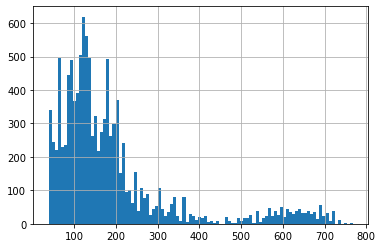

In [105]:
df['temps_trajet'].hist(bins = 100)

In [115]:
df['min_time']= df.groupby(['origine','destination'])['temps_trajet'].transform('min')
df['mean_time']= df.groupby(['origine','destination'])['temps_trajet'].transform('mean')


In [112]:
import seaborn as sns
import matplotlib.pyplot as plt

(-5.0979853649999995, 8.364020665, 42.01129483, 51.46403857)

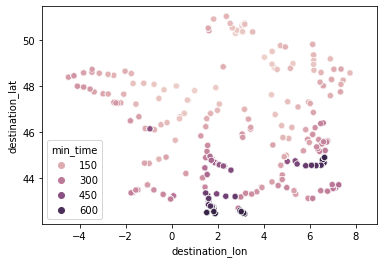

In [121]:
sns.scatterplot(data = df, x = 'destination_lon', y = 'destination_lat', hue = "min_time")
plt.axis('equal')

In [124]:
df = df.sort_values('datetime_depart')

# plot map per day

In [138]:
date = '2022-04-01'

In [139]:
df_trip = df[df['date'] == date].copy()

In [142]:
center_lat, center_lon = 46.871826, 2.459010
max_time = 60*((df_trip['min_time'].max() // 60)+1)
df_trip['time_since_departure_str']  = df_trip['temps_trajet'].astype(str)

from bokeh.io import show
from bokeh.plotting import gmap, output_file
from bokeh.models import ColumnDataSource, HoverTool, ColorBar, GMapOptions
from bokeh.transform import linear_cmap
from bokeh.palettes import Plasma256 as palette

bokeh_width, bokeh_height = 500,400

def plot_circles(df, lat, lng, zoom=5, map_type='roadmap', save = False):
    gmap_options = GMapOptions(lat=lat, lng=lng, 
                               map_type=map_type, zoom=zoom)

    hover = HoverTool(
        tooltips = [
            # @price refers to the price column
            # in the ColumnDataSource. 
            ('ville', '@destination'),
            ('temps', '@temps_trajet'), 
        ]
    )
    p = gmap(gg_key, gmap_options, title='France', 
             width=bokeh_width, height=bokeh_height,
             tools=[hover, 'reset', 'wheel_zoom', 'pan'])
    # definition of the column data source: 
    source = ColumnDataSource(df)

    mapper = linear_cmap('temps_trajet', palette, 0., max_time)    
    # see how we specify the x and y columns as strings, 
    # and how to declare as a source the ColumnDataSource:
    center = p.circle('destination_lon', 'destination_lat', size=10, alpha=1, 
                      color=mapper, source=source)
    # and we add a color scale to see which values the colors 
    # correspond to 
    color_bar = ColorBar(color_mapper=mapper['transform'], 
                         location=(0,0))
    p.add_layout(color_bar, 'right')
    if save:
        output_file('train_from_paris_map.html')
    show(p)
    return p

In [143]:
plot_circles(df_trip, center_lat, center_lon, save = True)

GMap(id='1004', ...)